In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers # solve IRL

# Helper Functions

## Conversion and Plot

In [2]:
def grid_to_value(grid, moving_reward=0, terminal_value=10, obstacle_value=-10):
    grid = np.array(grid)
    res = np.zeros(grid.shape)
    res[grid==' '] = moving_reward
    res[grid=='T'] = terminal_value
    res[grid=='#'] = obstacle_value
    return res

In [43]:
def plot_heatmap(rf):
    plt.imshow(rf, interpolation='nearest')
    plt.colorbar()
    # plt.title(title)
    plt.show()

In [156]:
def plot_heatmap(grid, rf):
    plt.imshow(rf, interpolation='nearest')
    plt.colorbar()
    grid = np.array(grid)
    h, w = rf.shape
    for y in range(h):
        for x in range(w):
            if grid[y,x] == 'T':
                plt.plot(x, y, marker="*", color='black', markersize=14)
            if grid[y,x] == '#':
                plt.plot(x, y, marker="X", color='red', markersize=8)
    # plt.title(title)
    plt.show()

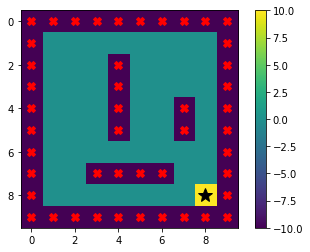

In [157]:
plot_heatmap(obstacle_grid, rf2)

In [154]:
def plot_policy(grid, vs, policy):
    '''
    Given grid map, value state map, and policy map
    Plot the policy arrows with value heatmap
    '''
    grid = np.array(grid)
    assert grid.shape == vs.shape and vs.shape == policy.shape
    # BEGIN Copy from plot_heatmap
    plt.imshow(vs, interpolation='nearest')
    plt.colorbar()
    grid = np.array(grid)
    h, w = vs.shape
    for y in range(h):
        for x in range(w):
            if grid[y,x] == 'T':
                plt.plot(x, y, marker="*", color='black', markersize=14)
            if grid[y,x] == '#':
                plt.plot(x, y, marker="X", color='red', markersize=8)
    # END Copy from plot_heatmap
    h, w = policy.shape
    arrow_len = 0.4
    for y in range(h):
        for x in range(w):
            if grid[y, x] == 'T': # skips terminal
                continue
            dx, dy = 0, 0
            if policy[y, x] == 0: # right / east
                dx = arrow_len
            elif policy[y, x] == 1: # left / west
                dx = -arrow_len
            elif policy[y, x] == 2: # up / north
                dy = -arrow_len
            else: # down / south
                dy = arrow_len 
            plt.arrow(x, y, dx, dy, head_width=0.2, color="white")
    plt.show()

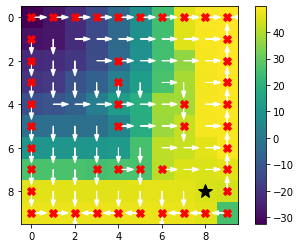

In [155]:
plot_policy(obstacle_grid, Vs2_irl_max_t, policy2_irl_max_t)

In [5]:
def plot_table(data):
    fig = plt.figure()
    ax = fig.add_subplot(111)   
    col_labels = list(range(0,10))
    row_labels = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ', 
                  ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

    # Draw table
    value_table = plt.table(cellText=data, colWidths=[0.05] * 10,
                          rowLabels=row_labels, colLabels=col_labels,
                          loc='center')
    value_table.auto_set_font_size(True)
    value_table.set_fontsize(24)
    value_table.scale(2.5, 2.5)

    # Removing ticks and spines enables you to get the figure only with table
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)

## Reinforcement Learning

In [6]:
def value_iteration(P, R, n_states=100, n_actions=4, discount_factor=0.8, threshold=0.01):
    Vs= np.zeros(n_states)
    delta=float('inf')
    while delta> threshold:
        delta=0
        temp=Vs
        for s in range(n_states): #s is in range of [0,100)
            v=Vs[s]
            Va=np.zeros(n_actions)
            for a in range(n_actions): #a is in range of [0,4)
                Vsp=np.zeros(n_states)
                for sp in range(n_states): #sp is in range of [0,100)
                    Vsp[sp] = P[a][s][sp]*(R[sp] + discount_factor*temp[sp])
                Va[a]=np.sum(Vsp)
            Vs[s]=max(Va)
            delta=max(delta, np.abs(v-Vs[s]))
    
    policy= np.zeros(n_states)
    for s in range(n_states): #s is in range of [0,100)
        Va=np.zeros(n_actions)
        for a in range(n_actions):
            Vsp=np.zeros(n_states)
            for sp in range(n_states): #sp is in range of [0,100)
                Vsp[sp] = P[a][s][sp]*(R[sp] + discount_factor*temp[sp])
            Va[a]=np.sum(Vsp)        
        policy[s] =np.argmax(Va) #return the index of maximum Va
    return Vs, policy   

## Inverse Reinforcement Learning

In [7]:
def irl(P, policy, Rmax, l1, n_states=100, n_actions=4, discount_factor=0.8):
    tran_prob=np.array(P)
    c= -np.hstack([np.ones(n_states), -l1*np.ones(n_states), np.zeros(n_states)])
    
    b = np.zeros((n_states*(n_actions-1)*2 + 2*n_states, 1))
    b_bounds = np.vstack([Rmax*np.ones((n_states, 1))]*2)
    b = np.vstack((b, b_bounds))
    
    def T(a, s):
        return np.dot(tran_prob[int(policy[s]), s] - tran_prob[a, s], 
                  np.linalg.inv(np.eye(n_states) - discount_factor*tran_prob[int(policy[s])]))
    A = set(range(n_actions)) 
    zero_stack1 = np.zeros((n_states*(n_actions-1), n_states))
    T_stack = np.vstack([-T(a, s)
            for s in range(n_states)
            for a in A - {policy[s]}
        ])
    I_stack1 = np.vstack([np.eye(1, n_states, s)
            for s in range(n_states)
            for a in A - {policy[s]}
        ])
    I_stack2 = np.eye(n_states)
    zero_stack2 = np.zeros((n_states, n_states))
    
    D_left = np.vstack([I_stack1, zero_stack1, zero_stack2, zero_stack2])
    D_middle = np.vstack([zero_stack1, zero_stack1, -I_stack2, -I_stack2])
    D_right = np.vstack([T_stack, T_stack, I_stack2, -I_stack2])

    D = np.hstack([D_left, D_middle, D_right])
    
    D_bounds = np.hstack([
            np.vstack([
                np.zeros((n_states, n_states)),
                np.zeros((n_states, n_states))]),
            np.vstack([
                np.zeros((n_states, n_states)),
                np.zeros((n_states, n_states))]),
            np.vstack([
                np.eye(n_states),
                -np.eye(n_states)])
            ])   
    D = np.vstack((D, D_bounds))
    
    solvers.options['show_progress'] = False
    sol=solvers.lp(matrix(c),matrix(D),matrix(b))
    R_irl=np.asarray(sol['x'][(2*n_states):])
    R_irl=R_irl.reshape((n_states,))
    return R_irl

In [8]:
def get_accuracy(P, rf, policy):
    n_states = len(rf.flatten())
    L = np.arange(0, 5, 5/500)
    accuracy = np.zeros(500)
    i = 0
    policy = policy.flatten()
    for l in L:
        R_irl = irl(P, policy, max(rf.T.flatten()), l)
        Vs_irl, policy_irl = value_iteration(P, R_irl)
        m = 0   
        for s in range(n_states):
            if (policy_irl[s]==policy[s]):       
                m+=1
        
        accuracy[i]=m/n_states
        i+=1
    
    return Vs_irl, policy_irl, accuracy

In [9]:
def plot_accuracy(x, y):
    plt.plot(x, y)
    plt.xlabel('$\lambda$')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs $\lambda$')
    plt.show()

# Construct Matrix P

In [10]:
w=0.1
Pr=np.zeros((100,100))
for s in range(len(Pr[0])):
    if (s==0):
        #print('s==0', s)
        Pr[s,s]=w/4+w/4
        Pr[s,s+1]=w/4
        Pr[s,s+10]=1-w+w/4
    elif (s>0) and (s<9):
        #print('s>0 and s<9', s)
        Pr[s,s-1]=w/4
        Pr[s,s]=w/4
        Pr[s,s+1]=w/4
        Pr[s,s+10]=1-w+w/4   
    elif (s==9):
        #print('s==9', s)
        Pr[s,s-1]=w/4
        Pr[s,s]=w/4+w/4
        Pr[s,s+10]=1-w+w/4
    elif (s%10==0) and (s>0) and (s<90):
        #print('s%10==0 and s>0 and s<9',s)
        Pr[s,s-10]=w/4
        Pr[s,s]=w/4
        Pr[s,s+1]=w/4
        Pr[s,s+10]=1-w+w/4          
    elif (s==90):
        #print('s==90', s)
        Pr[s,s-10]=w/4
        Pr[s,s]=1-w+w/4+w/4
        Pr[s,s+1]=w/4
    elif (s>90) and (s<99):
        #print('s>90 and s<99', s)
        Pr[s,s-10]=w/4
        Pr[s,s-1]=w/4
        Pr[s,s]=1-w+w/4
        Pr[s,s+1]=w/4
    elif ((s-9)%10==0) and (s>9) and (s<99):
        #print('s%9==0 and s>9 and s<99', s)
        Pr[s,s-10]=w/4
        Pr[s,s-1]=w/4
        Pr[s,s]=w/4
        Pr[s,s+10]=1-w+w/4
    elif (s==99):
        #print('s==99', s)
        Pr[s,s-10]=w/4
        Pr[s,s-1]=w/4
        Pr[s,s]=1-w+w/4+w/4
    else:
        #print('non boundry', s)
        Pr[s,s-10]=w/4
        Pr[s,s-1]=w/4
        Pr[s,s+1]=w/4
        Pr[s,s+10]=1-w+w/4
# print(Pr)

In [11]:
Pl=np.zeros((100,100))
for s in range(len(Pl[0])):
    if (s==0):
        #print('s==0', s)
        Pl[s,s]=1-w+w/4+w/4
        Pl[s,s+1]=w/4
        Pl[s,s+10]=w/4
    elif (s>0) and (s<9):
        #print('s>0 and s<9', s)
        Pl[s,s-1]=w/4
        Pl[s,s]=1-w+w/4
        Pl[s,s+1]=w/4
        Pl[s,s+10]=w/4   
    elif (s==9):
        #print('s==9', s)
        Pl[s,s-1]=w/4
        Pl[s,s]=1-w+w/4+w/4
        Pl[s,s+10]=w/4
    elif (s%10==0) and (s>0) and (s<90):
        #print('s%10==0 and s>0 and s<9',s)
        Pl[s,s-10]=1-w+w/4
        Pl[s,s]=w/4
        Pl[s,s+1]=w/4
        Pl[s,s+10]=w/4          
    elif (s==90):
        #print('s==90', s)
        Pl[s,s-10]=1-w+w/4
        Pl[s,s]=w/4+w/4
        Pl[s,s+1]=w/4
    elif (s>90) and (s<99):
        #print('s>90 and s<99', s)
        Pl[s,s-10]=1-w+w/4
        Pl[s,s-1]=w/4
        Pl[s,s]=w/4
        Pl[s,s+1]=w/4
    elif ((s-9)%10==0) and (s>9) and (s<99):
        #print('s%9==0 and s>9 and s<99', s)
        Pl[s,s-10]=1-w+w/4
        Pl[s,s-1]=w/4
        Pl[s,s]=w/4
        Pl[s,s+10]=w/4
    elif (s==99):
        #print('s==99', s)
        Pl[s,s-10]=1-w+w/4
        Pl[s,s-1]=w/4
        Pl[s,s]=w/4+w/4
    else:
        #print('non boundry', s)
        Pl[s,s-10]=1-w+w/4
        Pl[s,s-1]=w/4
        Pl[s,s+1]=w/4
        Pl[s,s+10]=w/4
# print(Pl)

In [13]:
Pu=np.zeros((100,100))
for s in range(len(Pu[0])):
    if (s==0):
        # print('s==0', s)
        Pu[s,s]=1-w+w/4+w/4
        Pu[s,s+1]=w/4
        Pu[s,s+10]=w/4
    elif (s>0) and (s<9):
        # print('s>0 and s<9', s)
        Pu[s,s-1]=1-w+w/4
        Pu[s,s]=w/4
        Pu[s,s+1]=w/4
        Pu[s,s+10]=w/4   
    elif (s==9):
        # print('s==9', s)
        Pu[s,s-1]=1-w+w/4
        Pu[s,s]=w/4+w/4
        Pu[s,s+10]=w/4
    elif (s%10==0) and (s>0) and (s<90):
        # print('s%10==0 and s>0 and s<9',s)
        Pu[s,s-10]=w/4
        Pu[s,s]=1-w+w/4
        Pu[s,s+1]=w/4
        Pu[s,s+10]=w/4          
    elif (s==90):
        # print('s==90', s)
        Pu[s,s-10]=w/4
        Pu[s,s]=1-w+w/4+w/4
        Pu[s,s+1]=w/4
    elif (s>90) and (s<99):
        # print('s>90 and s<99', s)
        Pu[s,s-10]=w/4
        Pu[s,s-1]=1-w+w/4
        Pu[s,s]=w/4
        Pu[s,s+1]=w/4
    elif ((s-9)%10==0) and (s>9) and (s<99):
        # print('s%9==0 and s>9 and s<99', s)
        Pu[s,s-10]=w/4
        Pu[s,s-1]=1-w+w/4
        Pu[s,s]=w/4
        Pu[s,s+10]=w/4
    elif (s==99):
        # print('s==99', s)
        Pu[s,s-10]=w/4
        Pu[s,s-1]=1-w+w/4
        Pu[s,s]=w/4+w/4
    else:
        # print('non boundry', s)
        Pu[s,s-10]=w/4
        Pu[s,s-1]=1-w+w/4
        Pu[s,s+1]=w/4
        Pu[s,s+10]=w/4
# print(Pu)

In [14]:
Pd=np.zeros((100,100))
for s in range(len(Pd[0])):
    if (s==0):
        # print('s==0', s)
        Pd[s,s]=w/4+w/4
        Pd[s,s+1]=1-w+w/4
        Pd[s,s+10]=w/4
    elif (s>0) and (s<9):
        # print('s>0 and s<9', s)
        Pd[s,s-1]=w/4
        Pd[s,s]=w/4
        Pd[s,s+1]=1-w+w/4
        Pd[s,s+10]=w/4 
    elif (s==9):
        # print('s==9', s)
        Pd[s,s-1]=w/4
        Pd[s,s]=1-w+w/4+w/4
        Pd[s,s+10]=w/4
    elif (s%10==0) and (s>0) and (s<90):
        # print('s%10==0 and s>0 and s<9',s)
        Pd[s,s-10]=w/4
        Pd[s,s]=w/4
        Pd[s,s+1]=1-w+w/4 
        Pd[s,s+10]=w/4     
    elif (s==90):
        # print('s==90', s)
        Pd[s,s-10]=w/4
        Pd[s,s]=w/4+w/4
        Pd[s,s+1]=1-w+w/4
    elif (s>90) and (s<99):
        # print('s>90 and s<99', s)
        Pd[s,s-10]=w/4
        Pd[s,s-1]=w/4
        Pd[s,s]=w/4
        Pd[s,s+1]=1-w+w/4
    elif ((s-9)%10==0) and (s>9) and (s<99):
        # print('s%9==0 and s>9 and s<99', s)
        Pd[s,s-10]=w/4
        Pd[s,s-1]=w/4
        Pd[s,s]=1-w+w/4
        Pd[s,s+10]=w/4
    elif (s==99):
        # print('s==99', s)
        Pd[s,s-10]=w/4
        Pd[s,s-1]=w/4
        Pd[s,s]=1-w+w/4+w/4
    else:
        # print('non boundry', s)
        Pd[s,s-10]=w/4
        Pd[s,s-1]=w/4
        Pd[s,s+1]=1-w+w/4
        Pd[s,s+10]=w/4
# print(Pd)

In [15]:
P=[Pr, Pl, Pu, Pd]
# P

# Basic Gridworld

Old basic gridworld

In [4]:
basic_grid = [[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'T']]

In [153]:
rf1 = grid_to_value(basic_grid, terminal_value=1)
rf1

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

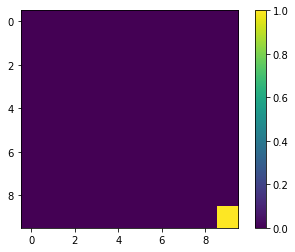

In [99]:
plot_heatmap(rf1)

Basic gridworld

In [165]:
basic_grid = [[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'T', ' '],
              [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']]

In [166]:
rf1 = grid_to_value(basic_grid)
rf1

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

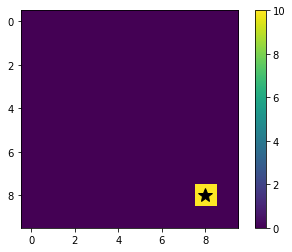

In [167]:
plot_heatmap(basic_grid, rf1)

## Reinforcement Learning

In [168]:
Vs1, policy1 = value_iteration(P, rf1.T.flatten())
Vs1 = Vs1.reshape(10,10).T
policy1 = policy1.reshape(10,10).T
print(Vs1)
print(policy1)

[[ 0.69051504  0.87787125  1.11876194  1.42361601  1.80966287  2.29879587
   2.91872803  3.70089975  4.46110874  3.84031519]
 [ 0.87787125  1.09710627  1.40066735  1.78736136  2.27963164  2.90659261
   3.70466334  4.70292474  5.70509986  4.86226918]
 [ 1.11876194  1.40066735  1.78635519  2.2788904   2.90622065  3.70538776
   4.72290417  6.00188756  7.33125391  6.18186433]
 [ 1.42361601  1.78736136  2.2788904   2.90620614  3.7054035   4.72368113
   6.02074393  7.65851054  9.42421985  7.85774082]
 [ 1.80966287  2.27963164  2.90622065  3.7054035   4.72369185  6.02126423
   7.67458623  9.77029458 12.11841687  9.98481332]
 [ 2.29879587  2.90659261  3.70538776  4.72368113  6.02126423  7.67483357
   9.78214134 12.46165172 15.58799869 12.68355688]
 [ 2.91872803  3.70466334  4.72290417  6.02074393  7.67458623  9.78214134
  12.46794304 15.890718   20.05805212 16.10624346]
 [ 3.70089975  4.70292474  6.00188756  7.65851054  9.77029458 12.46165172
  15.890718   20.25837467 25.81964863 20.44518782]


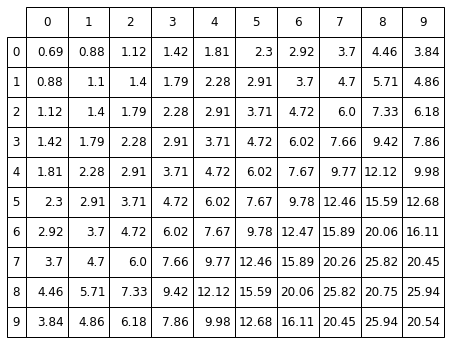

In [169]:
plot_table(Vs1.round(2))

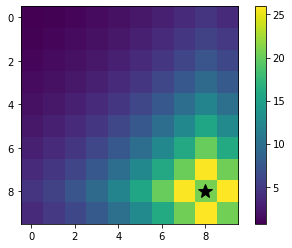

In [170]:
# Optimal state values heatmap
plot_heatmap(basic_grid, Vs1)

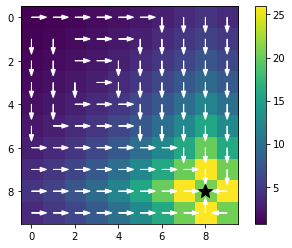

In [171]:
plot_policy(basic_grid, Vs1, policy1)

## Inverse Reinforcement Learning

In [172]:
# Runtime: about 10 minutes
Vs_irl1, policy_irl1, accuracy1 = get_accuracy(P, rf1, policy1)

Pick the best lambda

In [173]:
accuracy1

array([0.64, 0.64, 0.64, 0.65, 0.65, 0.65, 0.65, 0.64, 0.65, 0.66, 0.66,
       0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.67,
       0.67, 0.67, 0.67, 0.67, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69,
       0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.71, 0.72, 0.72, 0.72,
       0.74, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.74, 0.74, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.76, 0.74, 0.73, 0.74, 0.74, 0.74, 0.73,
       0.73, 0.72, 0.72, 0.72, 0.69, 0.69, 0.7 , 0.7 , 0.7 , 0.69, 0.69,
       0.69, 0.69, 0.69, 0.69, 0.7 , 0.7 , 0.7 , 0.69, 0.69, 0.69, 0.7 ,
       0.69, 0.7 , 0.69, 0.7 , 0.68, 0.69, 0.65, 0.65, 0.65, 0.65, 0.65,
       0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65,
       0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65,
       0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65,
       0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65,
       0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.

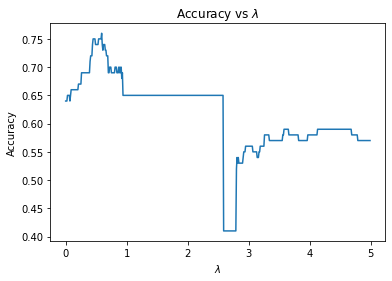

In [174]:
L1 = np.arange(0, 5, 5/500) # lambda candidates
plot_accuracy(L1, accuracy1)

In [175]:
max_index1=np.where(accuracy1==max(accuracy1))
l1_max1=L1[max_index1]
l1_max1

array([0.59])

Extracted Basic Gridworld

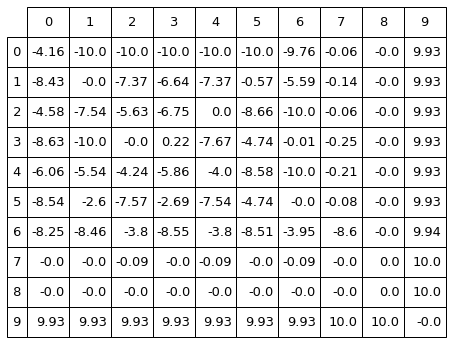

In [176]:
R_irl1_max= irl(P, policy1.flatten(), max(rf1.T.flatten()), l1_max1[0])
plot_table(R_irl1_max.round(2).reshape(10,10))

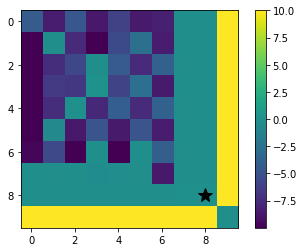

In [177]:
R_irl1_max_t= R_irl1_max.reshape(10,10).T
plot_heatmap(basic_grid, R_irl1_max_t) # Linear Program IRL: Basic Gridworld

Extracted Basic Gridworld: Optimal State Values

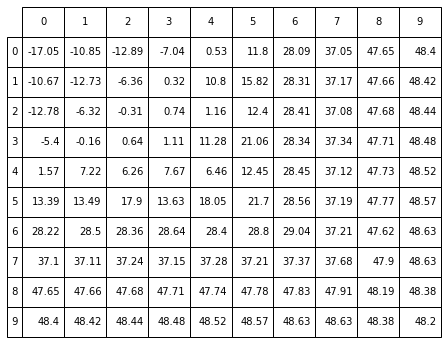

In [178]:
Vs1_irl_max, policy1_irl_max = value_iteration(P, R_irl1_max)
Vs1_irl_max_t=Vs1_irl_max.reshape(10,10).T
# print(Vs1_irl_max.round(2).reshape(10,10))
plot_table(Vs1_irl_max.round(2).reshape(10,10))

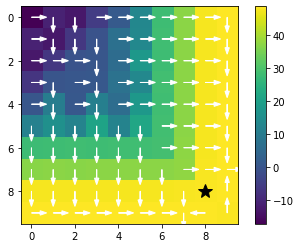

In [179]:
policy1_irl_max_t = policy1_irl_max.reshape(10,10).T
plot_policy(basic_grid, Vs1_irl_max_t, policy1_irl_max_t)

# Obstacle Gridworld

In [211]:
obstacle_grid = [['#', '#', '#', '#', '#', '#', '#', '#', '#', '#'],
                 ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
                 ['#', ' ', ' ', ' ', '#', ' ', ' ', ' ', ' ', '#'],
                 ['#', ' ', ' ', ' ', '#', ' ', ' ', ' ', ' ', '#'],
                 ['#', ' ', ' ', ' ', '#', ' ', ' ', '#', ' ', '#'],
                 ['#', ' ', ' ', ' ', '#', ' ', ' ', '#', ' ', '#'],
                 ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
                 ['#', ' ', ' ', '#', '#', '#', '#', ' ', ' ', '#'],
                 ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'T', '#'],
                 ['#', '#', '#', '#', '#', '#', '#', '#', '#', '#']]

In [212]:
# rf2 = grid_to_value(obstacle_grid)
rf2 = grid_to_value(obstacle_grid, obstacle_value=-1) # Try obstacle with different negative values
rf2

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [-1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.],
       [-1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.],
       [-1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0., -1.],
       [-1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0., -1.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [-1.,  0.,  0., -1., -1., -1., -1.,  0.,  0., -1.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

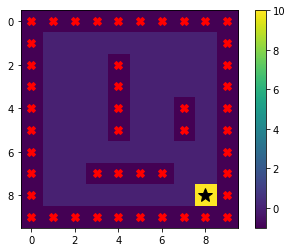

In [214]:
plot_heatmap(obstacle_grid, rf2)

## Reinforcement Learning

In [215]:
Vs2, policy2 = value_iteration(P, rf2.T.flatten())
Vs2 = Vs2.reshape(10,10).T
policy2 = policy2.reshape(10,10).T
print(Vs2)
print(policy2)

[[-0.52657345  0.6586207   0.94638059  1.2068824   1.58753497  2.10095892
   2.72435284  3.36370494  4.13836767  2.26788473]
 [ 0.65865288  0.96856455  1.30931346  1.63522584  2.11760764  2.76976275
   3.56366392  4.37217408  5.43102116  4.18270602]
 [ 0.94795728  1.31035285  1.71109952  2.12145106  2.76942563  3.56838793
   4.58449988  5.60940644  7.06475739  5.48874964]
 [ 1.24565066  1.68561842  2.18729896  2.73783269  3.52631553  4.56330062
   5.85219542  7.14829973  9.13484522  7.1214608 ]
 [ 1.62108082  2.16105974  2.79252455  3.52381119  4.52598198  5.83679096
   7.4689688   9.24468687 11.80222207  9.22472298]
 [ 2.09819113  2.76589091  3.56293255  4.5255083   5.83539928  7.47485057
   9.56203574 12.20932736 15.27098469 11.95868267]
 [ 2.69844456  3.53123747  4.54384574  5.80137747  7.437177    9.55557073
  12.22224587 15.61238477 19.73228856 15.47504141]
 [ 3.29674749  4.28483576  5.49484626  7.11214566  9.19651199 11.91786897
  15.60602631 19.93840664 25.44644758 19.97426782]


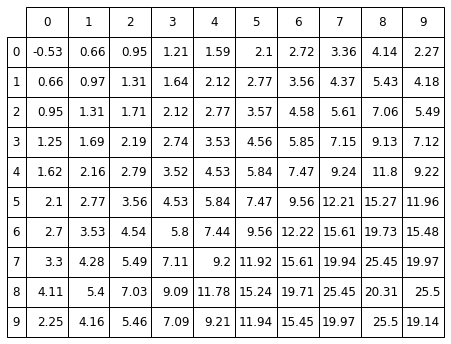

In [216]:
plot_table(Vs2.round(2))

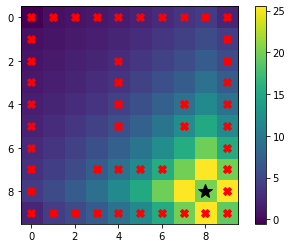

In [217]:
# Optimal state values heatmap
plot_heatmap(obstacle_grid, Vs2)

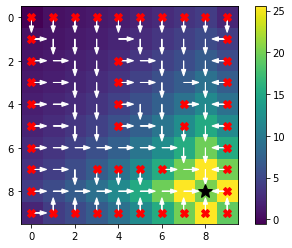

In [218]:
plot_policy(obstacle_grid, Vs2, policy2)

## Inverse Reinforcement Learning

In [219]:
# Runtime: about 10 minutes
Vs_irl2, policy_irl2, accuracy2 = get_accuracy(P, rf2, policy2)

Pick the best lambda

In [220]:
accuracy2

array([0.81, 0.81, 0.81, 0.81, 0.81, 0.79, 0.79, 0.79, 0.8 , 0.8 , 0.82,
       0.82, 0.82, 0.83, 0.83, 0.85, 0.85, 0.85, 0.84, 0.83, 0.82, 0.82,
       0.82, 0.78, 0.78, 0.77, 0.76, 0.74, 0.73, 0.73, 0.73, 0.71, 0.73,
       0.76, 0.76, 0.76, 0.74, 0.76, 0.75, 0.75, 0.76, 0.76, 0.76, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.76, 0.76, 0.76, 0.76, 0.77,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.77, 0.77, 0.79,
       0.78, 0.78, 0.78, 0.77, 0.76, 0.78, 0.78, 0.78, 0.78, 0.78, 0.75,
       0.75, 0.75, 0.76, 0.76, 0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.76, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.72, 0.72, 0.72, 0.72,
       0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71,
       0.71, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72,
       0.72, 0.72, 0.72, 0.72, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71,
       0.71, 0.71, 0.71, 0.72, 0.72, 0.74, 0.72, 0.72, 0.72, 0.72, 0.72,
       0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.

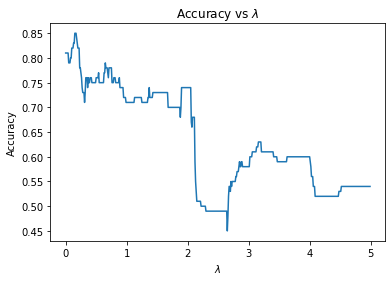

In [221]:
L2 = np.arange(0, 5, 5/500) # same as L1 here, lambda candidates
plot_accuracy(L2, accuracy2)

In [222]:
max_index2=np.where(accuracy2==max(accuracy2))
l2_max2=L2[max_index2]
l2_max2

array([0.15, 0.16, 0.17])

Extracted Obstacle Gridworld

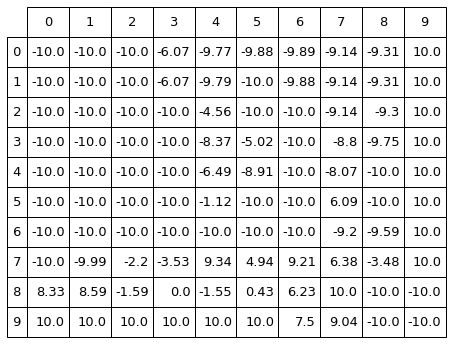

In [227]:
R_irl2_max= irl(P, policy2.flatten(), max(rf2.T.flatten()), l2_max2[0])
# R_irl2_max= irl(P, policy2.flatten(), max(rf2.T.flatten()), 0) # try to remove the decay-like penalty
plot_table(R_irl2_max.round(2).reshape(10,10))

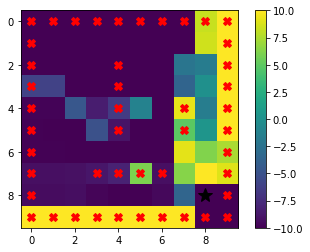

In [228]:
R_irl2_max_t= R_irl2_max.reshape(10,10).T
plot_heatmap(obstacle_grid, R_irl2_max_t) # Linear Program IRL: Obstalce Gridworld

Extracted Obstacle Gridworld: Optimal State Values

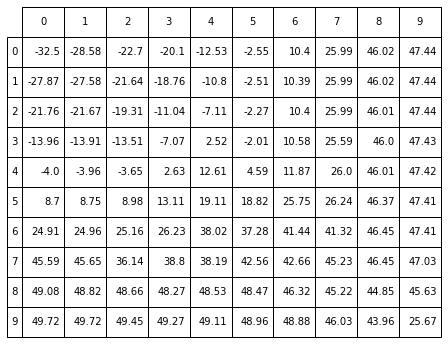

In [229]:
Vs2_irl_max, policy2_irl_max = value_iteration(P, R_irl2_max)
Vs2_irl_max_t=Vs2_irl_max.reshape(10,10).T
# print(Vs1_irl_max.round(2).reshape(10,10))
plot_table(Vs2_irl_max.round(2).reshape(10,10))

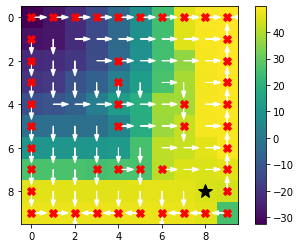

In [230]:
policy2_irl_max_t = policy2_irl_max.reshape(10,10).T
plot_policy(obstacle_grid, Vs2_irl_max_t, policy2_irl_max_t)